# Two excitation limit SSH Model
Now the Hamiltonian is of the form:
$$H=H_{SSH}+H_{int}$$
Where the Hamiltonian of the interaction is:
$$H_{int}=\frac{1}{2}\sum_i U a_i^\dagger a_i^\dagger a_i a_i=\frac{1}{2}\sum_i U n_i(n_i-1)  $$
The basis in which we will be working is:
$$\mathfrak{B}=\left\{ |10 \cdots 010 \cdots \rangle , |020\cdots 0\rangle, \cdots \right\}$$
Where the first ket represents a bosonic excitation in the first cell and another in the i-th cell, the second ket represents the two bosons in the second cell.

As the particles with which we are working are bosons there can be two of them in the same state.

First we will study the Bose-Hubbard dimer, two particles, with hopping $J$ between them and repulsion energy $U$.

In [262]:
DisplayNumericalValues=False
#With Numba I can calculate all about a n=50 chain in 2:30 minutes!!!!!!

In [263]:
from sympy.interactive import printing
printing.init_printing(use_latex = True)

import numpy as np
import sympy as sp
import scipy as sc
from scipy.misc import derivative
from sympy import *
from numpy.linalg import eig
from numpy import sin
from numpy import pi
from sympy import Array
from sympy.matrices import Matrix
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import numba
from numba.types import *
from numba import prange

from scipy.optimize import curve_fit
from scipy.stats import linregress

In [264]:
#Here we consider m=1, ħ=1 and a lattice with distance L=1
L=1
N=20
J1=0.1
J2=1
U=5
ω=0
weight=0.01

In [265]:
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a(n):
    if n == 0:
        return (0,0)
    else:
        return (n-1, np.sqrt(n))

@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a_plus(n):

    return (n+1, np.sqrt(n+1))

In [266]:
@numba.jit(float64(float64[:],float64[:]), nopython = True, parallel = False)
def bracket(bra1, ket1):
    if np.all(bra1 == ket1):
        return 1
    else:
        return 0
    #print("Subalgoritmo bra-ket")
    #print(bra1, ket1)
    #print(resultado)

In [267]:
#@numba.jit(float64[:](int32[:], float64), nopython=True, fastmath=True, parallel=False)
def func(x, λ, A):
    return ((x-A)/λ)

In [268]:
#Este subalgoritmo calcula un elemento de matriz con un Hamiltoniano 
@numba.jit(float64(float64[:],float64[:],float64, int64, float64), nopython = True, parallel = False)
def Elemento_matriz_Hamiltoniano(bra, ket, U, N, ω):
    #print(bra,ket)
    #<bra|H|ket>
    n_eigval=N*(N+1)/2
    H=0

    ket_aux = np.empty(len(ket))
    ket_aux2 = np.empty(len(ket))
    bra_aux = np.empty(len(ket))

    bracket1 = bracket(bra, ket)

    H += np.sum(ω*ket*bracket1)
    H += np.sum(0.5*U*ket*(ket-1)*bracket1)
    
    ket_aux[:] = ket
    ket_aux2[:] = ket
    bra_aux[:] = bra
    if (N-1)%2==0:
        J=J1
    else:
        J=J2
    #P.B.C.
    #ket_aux[0], coef_term2=a(ket_aux[0])
    #H.B.C.
    ket_aux[0], coef_term2=0,0
    ket_aux[N-1], coef_term2_aux=a_plus(ket_aux[N-1])
    term2 = J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
    ket_aux2[N-1], coef_term3=a(ket_aux2[N-1])
    #P.B.C.
    #ket_aux2[0], coef_term3_aux=a_plus(ket_aux2[0])
    #H.B.C.
    ket_aux2[0], coef_term3_aux=0,0
    term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
    H+=term2+term3
    for i in range(len(ket)-1):
            ket_aux[:] = ket
            ket_aux2[:] = ket
            bra_aux[:] = bra
            #print("El valor de bra en el subalgoritmo")
            #print(bra)
            #coef_term2=coef_term2_aux=coef_term3=coef_term3_aux=0
            if i%2==0:
                J=-J1
            else:
                J=-J2
            
            #print("Entro en el else")
            ket_aux[i+1], coef_term2 = a(ket_aux[i+1])
            ket_aux[i], coef_term2_aux=a_plus(ket_aux[i])
            term2=J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
            ket_aux2[i], coef_term3=a(ket_aux2[i])
            ket_aux2[i+1], coef_term3_aux=a_plus(ket_aux2[i+1])
            term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)

            #print(term2, term3)
            H+=term2+term3
    #print("\n")
    return H

In [269]:
Identity=np.identity(N)
n_eigval=int(N*(N+1)/2)
base=np.empty((n_eigval, N))
counter=0
for l in range(N):
    for k in range(l,N):
        ketB=Identity[k,:]+Identity[l,:]
        #print(ketB)
        base[counter, :]=ketB
        counter+=1
if DisplayNumericalValues:
    for i in range(len(base[:,0])):
        print((base[i,:]))
        
n_eigval=int(N*(N+1)/2)
if ω==0:
    ω_array=(2*weight*(np.random.rand(N)-0.5))
else:
    ω_array=ω*(1+2*weight*(np.random.rand(N)-0.5))
ω_matrix=np.zeros((n_eigval, n_eigval))
counter=0
for l in range(N):
    for k in range(l,N):
        ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])/2
        counter+=1

In [270]:
@numba.jit(float64[:,:](float64,float64[:,:], int64), nopython = True, parallel = False)
def ComputeH(U,base, N):
    H = np.empty((n_eigval,n_eigval))
    for i2 in range(n_eigval):
        for j2 in range(n_eigval):
            H[i2,j2]=Elemento_matriz_Hamiltoniano(base[i2],base[j2], U, N, ω_matrix[i2, j2])
    return H

In [271]:
@numba.jit(float64[:, :](int64, float64, float64), nopython=True, parallel=False)
def FastHamiltonian(N, J1, J2):
    #Manera rapida de calcular el Hamiltoniano
    aux_N=int(N/2) #Numero de celdas
    H_int1=np.asarray([[0, 1], [1, 0]])
    aux1=np.kron(np.eye(aux_N), H_int1)
    aux2=np.eye(N, k=1)+np.eye(N, k=-1)-aux1
    aux3=np.zeros((N, N))
    for i in range(N):
        aux3[i, i]=ω_array[i]
    H=J1*aux1+J2*aux2+aux3
    #print(H)
    return H

In [272]:
@numba.jit(numba.types.Tuple((int64[:], int64[:], int64[:], float64[:], float64[:, :]))(int64), nopython = True, parallel = False)
def ComputeIndexes(N):    
    H1p=FastHamiltonian(N, J1, J2)
    eigval1p, eigvect1p=eig(H1p)
    idx1p = np.argsort(eigval1p)
    eigval1p = eigval1p[idx1p]
    eigvect1p=eigvect1p[:, idx1p]
    
    if DisplayNumericalValues:
        print(eigval1p)
    eigvalNeg=eigval1p[:int(N/2)]
    if J2>J1:
        InterestingIndex=np.argmax(eigvalNeg)
    else:
        InterestingIndex=-100000
    E_teorIndep=[]
    eigvect_teorIndep=np.empty((N, n_eigval))
    NumberIterations=0
    IndexEdgeEdge=[]
    IndexBulkEdge=[]
    counter=0
    #Edge_Edge_Energies=[2*eigval1p[InterestingIndex], eigval1p[InterestingIndex]+ eigval1p[InterestingIndex+1], 2*eigval1p[InterestingIndex+1]]
    for i in range(N):
        for j in range (i,N):
            E_teorIndep.append(eigval1p[i]+eigval1p[j])
            eigvect_teorIndep[:, counter]=(eigvect1p[:, i]*eigvect1p[:, j]+eigvect1p[:, j]*eigvect1p[:, i])/(np.sqrt(np.sum(np.abs((eigvect1p[:, i]*eigvect1p[:, j]+eigvect1p[:, j]*eigvect1p[:, i])**2))))
            if i== InterestingIndex or i==InterestingIndex+1:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexEdgeEdge.append(counter)
                else:
                    IndexBulkEdge.append(counter)
            else:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexBulkEdge.append(counter)
            counter+=1
    E_teorIndep=np.asarray(E_teorIndep)
    idx=np.argsort(E_teorIndep)
    E_teorIndep=E_teorIndep[idx]
    eigvect_teorIndep=eigvect_teorIndep[:, idx]
    for i in range(len(IndexEdgeEdge)):
        IndexEdgeEdge[i]=np.argmin(np.abs(idx-IndexEdgeEdge[i]))
    for i in range(len(IndexBulkEdge)):
        IndexBulkEdge[i]=np.argmin(np.abs(idx-IndexBulkEdge[i]))
    IndexBulkBulk=[]
    for k in range(len(E_teorIndep)):
        if k in IndexBulkEdge :
            dummy=1
        elif k in IndexEdgeEdge:
            dummy=2
        else:
            IndexBulkBulk.append(k)
    IndexEdgeEdge=np.asarray(IndexEdgeEdge)
    IndexBulkEdge=np.asarray(IndexBulkEdge)
    IndexBulkBulk=np.asarray(IndexBulkBulk)
    #print(IndexEdgeEdge)
    #print(out)
    return (IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep, eigvect_teorIndep)

In [273]:
#Calculamos la matriz del Hamiltoniano
H=ComputeH(U, base, N)
if DisplayNumericalValues:
    print(H)

In [274]:
#Sacamos autovalores y autovectores del Hamiltoniano
eigval, eigvect=eig(H)
idx = np.argsort(eigval) #Ordenamos los autovalores y autovectores
eigval = eigval[idx]
eigvect=eigvect[:,idx]
for i in range(len(eigval)):
    CompEqSchrod=np.abs(np.matmul(H, eigvect[:, i])-eigval[i]*eigvect[:,i]) #Comparamos con la ecuación de Schrodinger
    if (np.any(CompEqSchrod>1e-12)):
        print("PROBLEMAS")
        print(CompEqSchrod)
if DisplayNumericalValues:
    print(eigvect)
    #print(sum(eigvect[:,IndexEdgeEdge]**2))

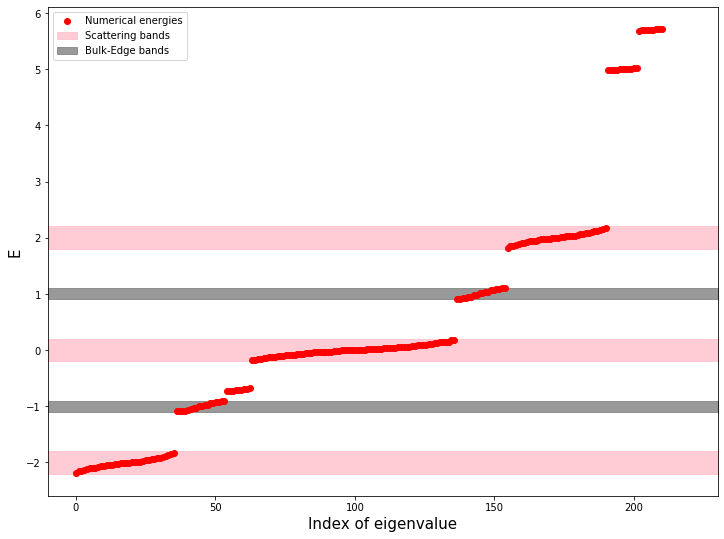

In [275]:
#Calculamos la relación de Dispersión
#IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep, eigvectIndep=ComputeIndexes(N)
a=np.linspace(0,len(eigval), len(eigval))
#E_analytical_Dimer=np.asarray([2*ω+ U - np.sqrt(U**2+4*J1**2),2*ω+2*U,2*ω+ U + np.sqrt(U**2+4*J1**2) ])
plt.figure(figsize=[12,9])
if U==0:
    IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep, eigvectIndep=ComputeIndexes(N)
    plt.scatter(a[IndexBulkBulk], eigval[IndexBulkBulk], color='red', label ='Bulk-Bulk States', zorder=10)
    plt.scatter(a[IndexEdgeEdge], eigval[IndexEdgeEdge], color='blue', label='Edge-Edge States', zorder=10)
    plt.scatter(a[IndexBulkEdge], eigval[IndexBulkEdge], color='black', label='Bulk-Edge States', zorder=10)
else:
    plt.scatter(a, eigval, color='red', label='Numerical energies')
#plt.plot(a, E_teorIndep, color='black', label='Non interacting bosons')
#plt.scatter(a, E_teorIndep, color='black', label='Non interacting bosons')
#plt.plot(a, E_analytical_Dimer, color='blue', label='Analytical results for Dimer')
plt.xlim(-10, 230)
aplot=np.linspace(-10, 230, 10)
#plt.savefig("DispersionRelation.png")
plt.ylabel("E", size=15)
plt.xlabel("Index of eigenvalue", size=15)
plt.fill_between(aplot, 2*J2-2*J1, 2*J2+2*J1, alpha=0.8, color='pink', zorder=0, label='Scattering bands')
plt.fill_between(aplot, -2*J1, 2*J1, alpha=0.8, color='pink', zorder=0)
plt.fill_between(aplot, -2*J2-2*J1, -2*J2+2*J1, alpha=0.8, color='pink', zorder=0)
plt.fill_between(aplot, J1+J2, J2-J1, alpha=0.8, color='gray', zorder=0, label='Bulk-Edge bands')
plt.fill_between(aplot, J1-J2, -J2-J1, alpha=0.8, color='gray', zorder=0)
plt.legend()
plt.show()
#print(eigval.real)
np.savetxt('energies.txt', eigval.real)

In [276]:
#Transformamos los autovectores a sus componentes sobre la cadena real
eigvecRealSpace=[[]]
eigvecRealSpace=np.matmul(base.transpose(), eigvect)
eigvecRealSpace=np.asarray(eigvecRealSpace)
#Normalizamos los autovectores en la cadena real
for j in range(n_eigval):
    eigvecRealSpace[:, j]=eigvecRealSpace[:,j]/np.sqrt(sum(np.abs(eigvecRealSpace[:,j])**2))
#print(np.sum(np.abs(eigvectIndep**2), axis = 0))

0.9644052102471053 0.34440629585228383
-3.058534393912101 1.5259005135098591


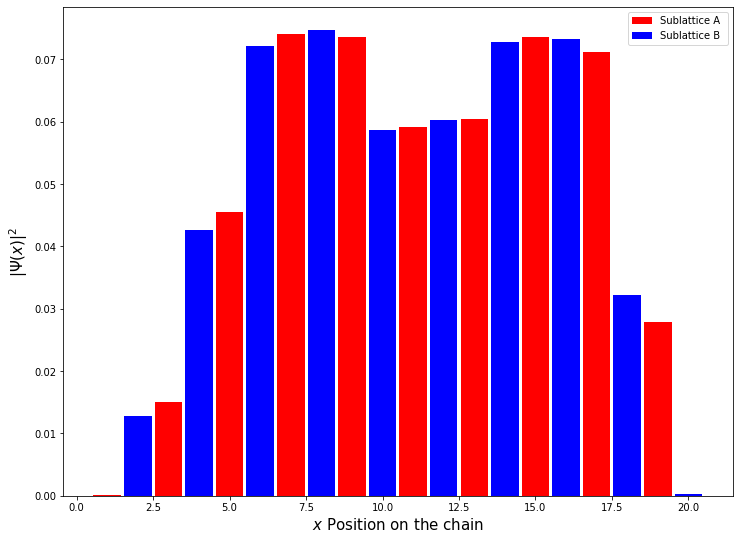

In [277]:
def PlotEigvect(i_Eig, eigvecRealSpace, eigvectIndep):
    #Expresiones analíticas para N=2
    """α0=np.sqrt(J1**2/(U**2+4*J1**2+U*np.sqrt(U**2+4*J1**2)))
    α2=np.sqrt(J1**2/(U**2+4*J1**2-U*np.sqrt(U**2+4*J1**2)))
    γ0=(-U-np.sqrt(U**2+4*J1**2))/(np.sqrt(2)*J1)
    γ2=(-U+np.sqrt(U**2+4*J1**2))/(np.sqrt(2)*J1)
    ψB=np.asarray([[α0, α0*γ0, α0], [1/np.sqrt(2), 0, -1/np.sqrt(2)], [α2, α2*γ2, α2]])
    ψBp=np.asarray([[2*α0+α0*γ0,2*α0+α0*γ0], [np.sqrt(2), -np.sqrt(2)], [2*α2+α2*γ2,2*α2+α2*γ2] ])
    """
    aux_eig=(abs(eigvecRealSpace[:, i_Eig]))**2
    x=np.arange(1, N+1, 1)
    #analytical_eig_Dimer=(abs(ψBp[i_Eig, :]))**2
    #xTeor=np.arange(0,L*len(analytical_eig_Dimer), 1)
    #Separamos en las contribuciones en las dos sublattices
    eigA= aux_eig[::2]
    eigB=aux_eig[1::2]
    minA=np.argmin(eigA)
    minB=np.argmin(eigB)
    maxA=np.argmax(eigA)
    maxB=np.argmax(eigB)
    xA=np.arange(1, L*len(eigvecRealSpace[:, 0])+1, 2 )
    xB=np.arange(2, L*len(eigvecRealSpace[:, 0])+1, 2)
    if maxA>minA:
        eigAuxA=eigA[minA:maxA+1]
        xAuxA=xA[minA:maxA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    else:
        eigAuxA=eigA[maxA:minA+1]
        xAuxA=xA[maxA:minA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    if maxB>minB:
        eigAuxB=eigB[minB:maxB+1]
        xAuxB=xB[minB:maxB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    else:
        eigAuxB=eigB[maxB:minB+1]
        xAuxB=xB[maxB:minB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    print(1/mA, errA/mA**2)
    print(1/mB, errB/mB**2)
    plt.figure(figsize=[12, 9])
    plt.bar(xA, eigA, width=0.9,color='red', label='Sublattice A ', zorder=0)
    plt.bar(xB, eigB, color='blue', width=0.9, label='Sublattice B ', zorder=0)
    #plt.plot(xAuxA, np.exp(mA*xAuxA+nA), color='red', label='Exponential fit A')
    #plt.plot(xAuxB, np.exp(mB*xAuxB+nB), color='blue', label='Exponential fit B')
    #plt.scatter(x, (abs(eigvectIndep[:, i]))**2, zorder=10, color='black', s=35)
    #plt.plot(xTeor, analytical_eig_Dimer, color='black', label='Analytical eigenvector')
    plt.xlabel("$x$ Position on the chain", size=15)
    plt.ylabel("$|Ψ(x)|^2$", size=15)
    #plt.title("Eigenvector number "+ str(i_Eig)+" using J1="+ str(J1)+" J2="+str(J2))
    plt.savefig('EigenVector'+str(i_Eig)+'.png')
    #plt.yscale('log')
    plt.legend()
    plt.show()

aux=np.arange(190, 210, 1)
#for i in aux:
    #PlotEigvect(i, eigvecRealSpace, eigvectIndep)
eigvectIndep=np.asarray([])
#for i in aux:
    #PlotEigvect(i, eigvecRealSpace, eigvectIndep)
PlotEigvect(0, eigvecRealSpace, eigvectIndep)

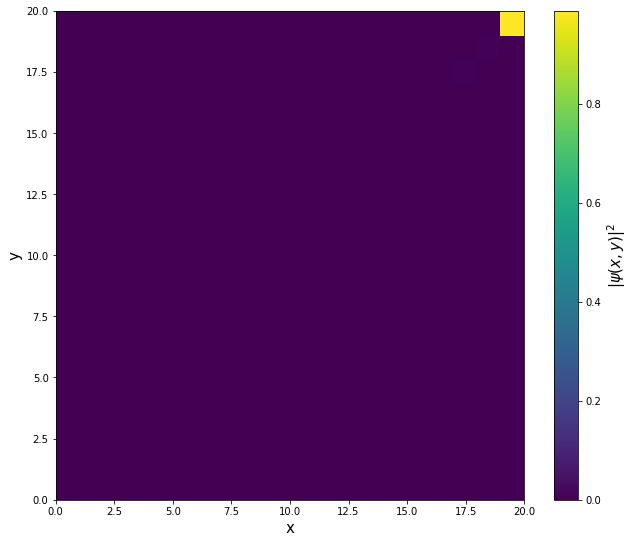

In [278]:
def PlotEigvect2D(i_Eig, eigvect):
    EigV_i=(abs(eigvect[:, i_Eig]))**2
    maxV=np.max(EigV_i)
    minV=np.max(EigV_i)
    eigvect2D=np.zeros((N, N))
    counter=0
    for i in range(N):
        for j in range(i, N):
            eigvect2D[i, j]=EigV_i[counter]
            eigvect2D[j, i]=EigV_i[counter]
            counter+=1
    plt.figure(figsize=[10.5, 9])
    plt.pcolor(eigvect2D)
    cb= plt.colorbar()
    cb.set_label(label="$|\psi(x,y)|^2$", size=15)
    plt.xlabel("x", size=15)
    plt.ylabel("y", size=15)
    """a=25
    x=np.linspace(0, a, 100)
    xa=np.linspace(0,20,100)
    xaa=np.linspace(0, a/2, 100)
    plt.plot(x, -x+a)
    plt.plot(xa, xa)
    plt.plot(a/2*np.ones(100),xaa)"""
    #plt.title("Mapping of the 2-particle wavefunction to a 2D plot \n Each of the axis represents the position on the lattice of one particle")
    plt.savefig("2DPlotEigvect"+str(i_Eig)+".png")
    plt.show()
#for i in aux:
PlotEigvect2D(199,  eigvect)

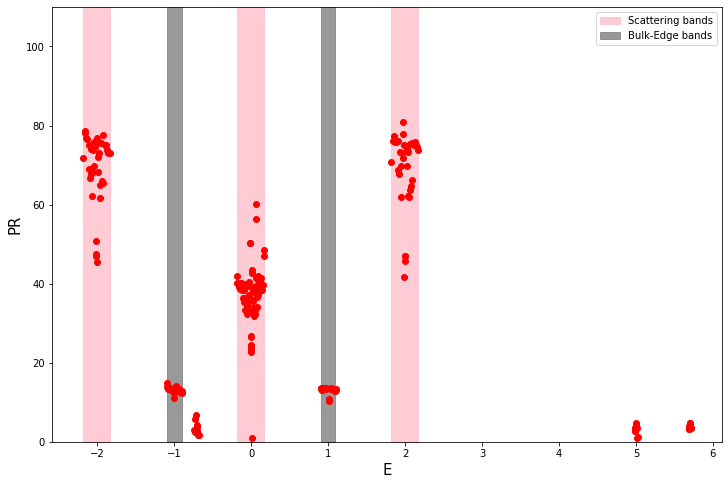

Elementos del array, ordenados de menor a mayor PR
[199 105 200  62  61  55  59 190 192  54 201 203 209 193 191 208 198 197
 204  60 202 195 205  58 196 194 207 206  56  57 145 144  45  44  53  50
 150  51 151  52 138  42 139 153  48  49 142  38 146 148 149  46  43 152
 137  39 143 147  41 141 140 136  40  37  47  36  98  97 101  95  96 102
 100  99 114  84 115  89  83 116  78 111 109 120  82  81  77  87 107 106
  74  73 121  92 124  91 125 113  76 112  72 132 130 108  68  75 126 110
  66  85 122 133  86 131  65  90  71  79  80  70  67  64  69 127  88 128
 119 129 170 123  63 104 103  19 173 171 134 172  16  18 135  94  93  17
 117 118  25 179 164  10 178 180 182  26  30  28 184   7 161   9  23  11
 159   5  14 163 175 154   0 168  21  35 165  34  24 162 177  33  12 189
 176   8  15 188 174 187   6  31 169 185  32 181 183  27 186  13  22 157
 158 160 155   4   3  20 156  29 167   1   2 166]


'print("Participation Ratio")\nprint(InterestingEigVects)\nprint(participation_ratio[InterestingEigVects])\nprint("Number of occupied sites by the state")\nprint(NumberOccupiedSites[InterestingEigVects])'

In [286]:
N_eigvect=len(eigvect[0, :])
participation_ratio=[]
NumberOccupiedSites=[]
participation_ratio = np.sum(np.abs(eigvect**2), axis = 0) / np.sum(np.abs(eigvect**4), axis = 0)
participation_ratio=np.asarray(participation_ratio)
NumberOccupiedSites=0.5*(np.sqrt(1+8*participation_ratio)-1)
plt.figure(figsize=[12, 8])
a=np.linspace(0,len(eigvect[0, :]),len(eigvect[0,:]))
if U==0:
    plt.scatter(eigval[IndexBulkBulk],participation_ratio[IndexBulkBulk], label='Bulk-Bulk States', color='red')
    plt.scatter(eigval[IndexEdgeEdge],participation_ratio[IndexEdgeEdge], label='Edge-Edge States', color='blue')
    plt.scatter(eigval[IndexBulkEdge],participation_ratio[IndexBulkEdge], label='Bulk-Edge States', color='black')
else:
    plt.scatter(eigval, participation_ratio, color='red')
plt.xlabel("E", size=15)
plt.ylabel("PR", size=15)
ymax=110
plt.fill_between(eigval, 0, ymax, where=(eigval>-2*J1-2*J2)&(eigval<-2*J2+2*J1), alpha=0.8, color='pink', zorder=0, label='Scattering bands')
plt.fill_between(eigval, 0, ymax, where=(eigval>-2*J1)&(eigval<2*J1), alpha=0.8, color='pink', zorder=0)
plt.fill_between(eigval, 0, ymax, where=(eigval>-2*J1+2*J2)&(eigval<2*J2+2*J1), alpha=0.8, color='pink', zorder=0)
plt.fill_between(eigval, 0, ymax, where=(eigval>-J1+J2)&(eigval<J2+J1), alpha=0.8, color='gray', zorder=0, label='Bulk-Edge bands')
plt.fill_between(eigval,  0, ymax, where=(eigval>-J1-J2)&(eigval<-J2+J1), alpha=0.8, color='gray', zorder=0)
plt.ylim(0,110)
#plt.title("Participation ratio as a function of the Energy of the eigenstate")
plt.legend()
plt.savefig("participation_ratio.png")
plt.show()
print("Elementos del array, ordenados de menor a mayor PR")
print(np.argsort(participation_ratio))
#participation_ratio=np.asarray(participation_ratio)
"""print("Participation Ratio")
print(InterestingEigVects)
print(participation_ratio[InterestingEigVects])
print("Number of occupied sites by the state")
print(NumberOccupiedSites[InterestingEigVects])"""

In [280]:
"""dummy=np.asarray([[5, 2, 10], [5, 3, 2]])
print((dummy[0,:]*dummy[1, :]+ dummy[1, :]*dummy[0, :])/(np.sqrt(2)))"""

'dummy=np.asarray([[5, 2, 10], [5, 3, 2]])\nprint((dummy[0,:]*dummy[1, :]+ dummy[1, :]*dummy[0, :])/(np.sqrt(2)))'

In [281]:
print(participation_ratio[61])

1.8206996859192197


In [282]:
print(np.mean(participation_ratio[IndexBulkBulk]))

41.89843525235762


In [283]:
print(np.argmin(participation_ratio[IndexBulkEdge]))

17


In [284]:
print(np.argpartition(participation_ratio, 3))

[199 105 200  62  61 190 191 203 209 201  54 193  59  55 192 208 197 195
 202 204 205  60 198  58 194  57  56 196 206 207 145 144  45  48 150 139
 151 138  53  52  51  50  42  49  44 153 142  47  46  43  41  40  39  38
  37  36 140 141 143 146 147 148 149  98 137 152 136  97 106 121 120 107
 124  73  74 102 101  77  78 100 116  81  82  83  84  99 125  87 115  89
 114  91  92 109 111  95  96 113  86  85 133  76  75  72 132  68 122  66
 108 130 110 126 112 131  90  88  80  79  71 119  70  69  67 123  64  63
 170 127 128 129  65 104 118 117 134 135   1 103  94  93  35  34  33  32
  31  30  29  28  27  26  25  24  23  22 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169  21 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189  20  19  18  17  16  15  14  13
  12  11  10   9   8   7   6   5   4   3   2   0]


In [285]:
print(eigval[45], eigval[62])

-1.0028909392930716 -0.6710003342525533
